# Clustering and prediction

To do inference, we convert active fire detections into fire events/fire clusters: sets of detections that are close enough together that we say that they came from the same fire. Note that because fires in Alaska can remain dormant for weeks or even months before springing back to life, we consider any detections that occur within 5km of each other (or are connected by a chain of fires, each within 5km of the next) to be part of the same fire if they occurred in the same year. This assumption wouldn't hold as well somewhere with less dormant-and-coming-back-to-life fires or without such a dormant winter (or in the southern hemisphere where their winter isn't over the year border!).

My fire clustering code sits in prediction.fire_clustering.cluster_over_time_with_merging, which takes one of my MODIS DataFrames and a clustering threshold. This code is pretty slow so I'm just going to load the resulting DataFrame (it can probably be made much faster, but maybe not a huge priority).

This DataFrame will be the same as the others but with a cluster field telling which cluster the detection belongs to. Note that I've only clustered fires that occur during the fire season (which I define as occuring between May 14 and August 31), so some cluster values will be NaN.

In [1]:
import os
REP_DIR = "/Users/zbutler/research/fire_prediction/"
os.chdir(REP_DIR)
from data import data
clust_df = data.load_clust_df(clust_thresh=5)
clust_df.iloc[0:5]

,confidence,day,frp,hour,lat,lon,minute,month,year,x,y,dayofyear,cluster
1448868,0.24,1,7.1,22,64.808,-147.609,19,5,2007,1046.361463,1088.688,121,NaN
1600851,0.53,17,13.3,22,60.046,-151.492,33,5,2007,862.434548,560.106,137,0.0
1610427,0.43,19,23.8,23,67.019,-158.293,44,5,2007,566.748464,1334.109,139,1.0
1623204,0.35,21,4.5,20,62.808,-138.762,16,5,2007,1509.981794,866.688,141,2.0
1628928,0.81,21,16.8,22,63.922,-146.422,9,5,2007,1110.487294,990.342,141,3.0


When two clusters start more than 5km apart and come within 5km of each other, I merge them into one cluster starting the day that they get close enough to each other. All points close to either fire from that day on will be said to be part of the large cluster. To keep track of this, I also store a merge_dict, which has merging clusters as keys and the clusters they merge into as values (with the day of merging also being stored in the value as the second element of a tuple)

In [2]:
merge_dict = data.load_merge_dict(clust_thresh=5)
merge_dict[200]

(254, 212.0)

For prediction purposes, I need a DataFrame that can easily be fed to a prediction package (in our case statsmodels), so I made a clust_feat_df which has one row per cluster per day. This DataFrame has the following columns:
* cluster: ID of the cluster (unique across all years)
* alt_cluster: if this cluster merges into another, this will be a tuple with the ID of the merger cluster and the time of the merge. Else, it will be NaN.
* lat_centroid, lon_centroid: Centroid of all of the cluster's detections. This could also be defined as the centroid of the detections up until that time, but it isn't at the moment.
* dayofyear,year: day in question.
* wind/temp/humidity/rain: Weather covariates on that day at the centroid of the cluster.
* rain_del_2: the rain variable, but from 2 days in the past (this leads to better predictions)

In [3]:
clust_feat_df = data.load_clust_feat_df(clust_thresh=5.)
clust_feat_df.iloc[0:5]

,cluster,alt_cluster,lat_centroid,lon_centroid,n_det,dayofyear,year,rain,wind,temp,humidity,rain_del_2
0,0.0,NaN,60.0460,-151.492,1.0,137.0,2007.0,0.0,3.324154,282.3,57.0,0.6
1,1.0,NaN,67.0195,-158.289,1.0,139.0,2007.0,0.0,1.081665,276.1,98.0,0.0
2,1.0,NaN,67.0195,-158.289,0.0,140.0,2007.0,0.0,0.300000,277.2,94.0,0.0
3,1.0,NaN,67.0195,-158.289,0.0,141.0,2007.0,1.1,1.941649,275.8,100.0,0.0
4,1.0,NaN,67.0195,-158.289,0.0,142.0,2007.0,5.3,2.195450,278.0,99.0,0.0


# Prediction
For prediction, I put this clust_feat_df into a statsmodel Poisson regression and return the result. I've made a ClusterRegression object for this purpose. To demonstrate, I will show how I made Figure 3 in our paper:

In [16]:
# First, get predictors
import metrics.evaluation as ev
import prediction.cluster_regression as cr
reload(ev)
import pandas as pd
import numpy as np
from metrics.evaluation import kill_nanners
mets_baseline = dict()
mets_mem = dict()
mets_temphum = dict()
mets_weather = dict()
met = "MeanAbsErr"
#cdf_with_stuff = cr.add_autoreg_and_n_det(clust_feat_df.copy(), autoreg_cols=10, t_k_max=0, zero_padding=False)
#cdf_with_stuff = kill_nanners(cdf_with_stuff.copy(), ["temp", "humidity", "wind", "rain_del_2"])
max_t_k = 4

for t_k in range(max_t_k,-1,-1):
    legit_series = pd.Series(index=cdf_with_stuff.index)
    for clust in cdf_with_stuff.cluster.unique():
        clust_df = cdf_with_stuff[cdf_with_stuff.cluster==clust]
        legit_day = np.min(clust_df.dayofyear) + t_k
        legit_series[clust_df[clust_df.dayofyear >= legit_day].index] = 1
    y_t_k_base = cdf_with_stuff[legit_series == 1]['n_det']
    y_hat_t_k_base = np.exp(cdf_with_stuff[legit_series == 1]["autoreg_%d" % (1 + t_k)]) - 1

    # Baseline
    mets_baseline[t_k] = (ev.evaluate_glm(y_t_k_base, y_hat_t_k_base, metric=met))
    
    # models
    mets_mem[t_k] = ev.cross_validation_evaluation(cdf_with_stuff, autoreg=1, t_k=t_k, weather_vars=[], zero_padding=False, return_arrs=False, max_t_k=t_k, legit_series=legit_series, metrics=[met])
    mets_temphum[t_k] = ev.cross_validation_evaluation(cdf_with_stuff, autoreg=1, t_k=t_k, weather_vars=["temp","humidity"], zero_padding=False, return_arrs=False, max_t_k=t_k, legit_series=legit_series, metrics=[met])
    mets_weather[t_k] = ev.cross_validation_evaluation(cdf_with_stuff, autoreg=1, t_k=t_k, weather_vars=["temp","humidity","wind","rain_del_2"], zero_padding=False, return_arrs=False, max_t_k=t_k, legit_series=legit_series, metrics=[met])
    print "done with t_k %d" % t_k

done with t_k 4
done with t_k 3
done with t_k 2
done with t_k 1
done with t_k 0


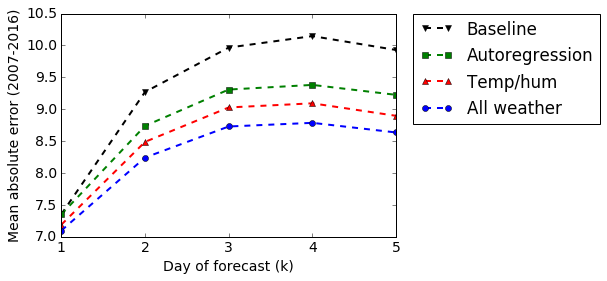

In [22]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

n_t_k = 5
t_k_arr = np.arange(n_t_k)
mets = ["MeanAbsErr"]
i = 0
for met in mets:
    base_arr = np.array(map(lambda x: mets_baseline[x], t_k_arr))
    mem_arr = np.array(map(lambda x: mets_mem[x][i], t_k_arr))
    temphum_arr = np.array(map(lambda x: mets_temphum[x][i], t_k_arr))
    weather_arr = np.array(map(lambda x: mets_weather[x][i], t_k_arr))
    
    plt.plot(t_k_arr+1, base_arr, "kv--", label="Baseline", linewidth=2)
    plt.plot(t_k_arr+1, mem_arr, "gs--", label="Autoregression", linewidth=2)
    plt.plot(t_k_arr+1, temphum_arr, "r^--", label="Temp/hum", linewidth=2)
    plt.plot(t_k_arr+1, weather_arr, "bo--", label="All weather", linewidth=2)
    
    matplotlib.rcParams.update({'font.size': 14})
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("Day of forecast (k)")
    plt.xticks(t_k_arr+1)
    plt.ylabel("Mean absolute error (2007-2016)")
    plt.savefig("pics/mae.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()